In [1]:
import numpy as np
import pandas as pd

### Read the data

In [2]:
df = pd.read_csv('top_genres_downsampled.csv', nrows=50000) # Loading only 50k rows for prototyping

### Cleaning the data

In [3]:
print(df['genre'].value_counts())

genre
r&b                         11967
country                     11627
other                        5379
pop,rock                     2833
metal                        2546
                            ...  
electronic,other,metal          1
other,electronic,country        1
rock,pop,r&b                    1
other,metal,country             1
other,electronic,hip-hop        1
Name: count, Length: 149, dtype: int64


In [4]:
print(df.head())

             genre                                             lyrics language
0  pop,hip-hop,r&b  [Verse 1] This shit remind me of how... look T...  english
1   electronic,pop  I was looking lost, it was cold outside The wh...  english
2          country  Ive been exalted, cried from the pulpit but Im...  english
3              r&b  [Lyrics from Snippet] [blackbear] Drugs, is ki...  english
4          country  A dually diesel pullin' hard with a horse trai...  english


In [5]:
print(df['language'].value_counts())

language
english    49634
russian      366
Name: count, dtype: int64


In [6]:
df = df[df['language'] == "english"].reset_index(drop=True) # Removing Russian songs since models trained on English text won’t do well on Russian text.

In [7]:
df.head()

,genre,lyrics,language
0,"pop,hip-hop,r&b",[Verse 1] This shit remind me of how... look T...,english
1,"electronic,pop","I was looking lost, it was cold outside The wh...",english
2,country,"Ive been exalted, cried from the pulpit but Im...",english
3,r&b,"[Lyrics from Snippet] [blackbear] Drugs, is ki...",english
4,country,A dually diesel pullin' hard with a horse trai...,english


In [8]:
# Convert "pop,hip-hop,r&b" to ["pop", "hip-hop", "r&b"], Handling Multi-Label Genres.
df["genre"] = df["genre"].apply(lambda x: x.split(","))

### Cleaning Lyrics

In [9]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)   # remove [Verse], [Chorus]
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters & spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['lyrics'] = df['lyrics'].astype(str).apply(clean_text)
print(df['lyrics'].head())

0    this shit remind me of how look this shit remi...
1    i was looking lost it was cold outside the whi...
2    ive been exalted cried from the pulpit but im ...
3    drugs is kickin in i can tell em xannies talki...
4    a dually diesel pullin hard with a horse trail...
Name: lyrics, dtype: object


### Encoding Genres

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genre'])

print("Genres:", mlb.classes_)
print("Shape of y:", y.shape)  # (num_samples, num_genres)

Genres: ['country' 'electronic' 'hip-hop' 'metal' 'other' 'pop' 'r&b' 'rock']
Shape of y: (49634, 8)


### Visualization

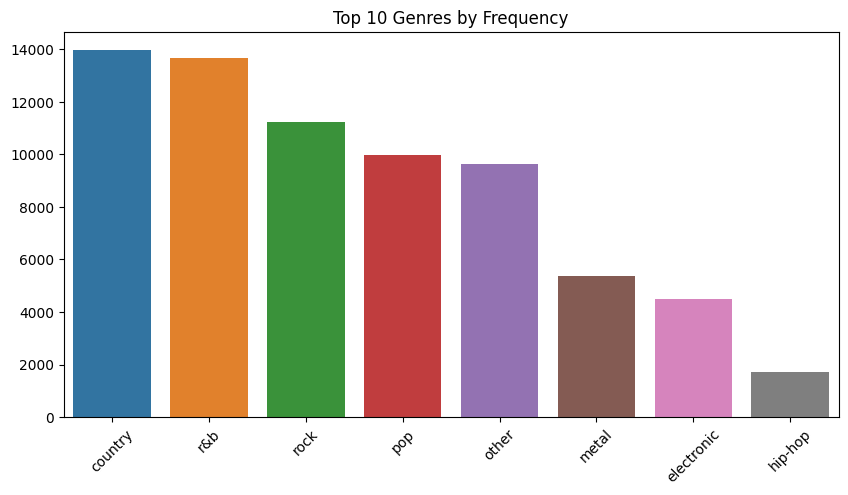

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 genres by frequency
genre_counts = pd.Series(y.sum(axis=0), index=mlb.classes_).sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=genre_counts.head(10).index, y=genre_counts.head(10).values)
plt.xticks(rotation=45)
plt.title("Top 10 Genres by Frequency")
plt.show()

### Vectorize Lyrics (TF-IDF)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_bigram = TfidfVectorizer(max_features=50000,   # cap vocabulary
                             ngram_range=(1, 2),   # unigrams + bigrams
                             stop_words="english") # remove stopwords

X = tfidf_bigram.fit_transform(df['lyrics'])

print("Shape of X:", X.shape)  # (num_samples, num_features)

Shape of X: (49634, 50000)


### Train/Test Split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (39707, 50000)  Test size: (9927, 50000)


### Baseline Model: Logistic Regression (One-vs-Rest Linear)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Logistic Regression with OvR for multi-label
model = OneVsRestClassifier(LogisticRegression(max_iter=1000, n_jobs=-1))
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, n_jobs=-1))

### Evaluation

In [15]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)

# Macro/micro F1 are more meaningful than accuracy in multi-label
print("Exact Match Accuracy:", accuracy_score(y_test, y_pred))  
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Exact Match Accuracy: 0.29676639468117255

Classification Report:

              precision    recall  f1-score   support

     country       0.77      0.44      0.56      2834
  electronic       0.91      0.01      0.02       902
     hip-hop       0.50      0.01      0.02       329
       metal       0.85      0.28      0.42      1033
       other       0.88      0.26      0.40      1950
         pop       0.76      0.05      0.09      1993
         r&b       0.76      0.50      0.60      2747
        rock       0.57      0.07      0.12      2227

   micro avg       0.77      0.26      0.39     14015
   macro avg       0.75      0.20      0.28     14015
weighted avg       0.76      0.26      0.35     14015
 samples avg       0.36      0.33      0.34     14015



C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Insights for Logistic Regression (One-vs-Rest Linear)

Performance: Very imbalanced. High precision but terrible recall for some classes (electronic, hip-hop, pop, rock).

Tends to predict only a few dominant genres and misses the rarer ones.

### Logistic Regression with class weights

In [16]:
clf = OneVsRestClassifier(
    LogisticRegression(
        max_iter=1000,
        class_weight="balanced",   # handles imbalance
        solver="liblinear"))

clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=1000,
                                                 solver='liblinear'))

### Evaluation

In [17]:
y_pred = clf.predict(X_test)

print("Exact Match Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Exact Match Accuracy: 0.24367885564621738

Classification Report:

              precision    recall  f1-score   support

     country       0.61      0.72      0.66      2834
  electronic       0.20      0.37      0.26       902
     hip-hop       0.17      0.41      0.25       329
       metal       0.42      0.71      0.53      1033
       other       0.45      0.55      0.49      1950
         pop       0.32      0.48      0.38      1993
         r&b       0.59      0.74      0.66      2747
        rock       0.36      0.56      0.44      2227

   micro avg       0.43      0.61      0.51     14015
   macro avg       0.39      0.57      0.46     14015
weighted avg       0.45      0.61      0.52     14015
 samples avg       0.49      0.66      0.53     14015



C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Insights for Logistic Regression with class weights

Weighted LR improves recall for rare genres (hip-hop, electronic, pop)

### SVM (One-vs-Rest Linear SVM)

In [18]:
from sklearn.svm import LinearSVC

svm = OneVsRestClassifier(
    LinearSVC(class_weight="balanced"))

svm.fit(X_train, y_train)

OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced'))

### Evaluation

In [19]:
y_pred = svm.predict(X_test)

print("Exact Match Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report (SVM):\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Exact Match Accuracy: 0.27611564420267953

Classification Report (SVM):

              precision    recall  f1-score   support

     country       0.63      0.65      0.64      2834
  electronic       0.21      0.23      0.21       902
     hip-hop       0.25      0.22      0.23       329
       metal       0.48      0.55      0.51      1033
       other       0.45      0.49      0.47      1950
         pop       0.32      0.39      0.35      1993
         r&b       0.60      0.68      0.64      2747
        rock       0.36      0.45      0.40      2227

   micro avg       0.46      0.52      0.49     14015
   macro avg       0.41      0.46      0.43     14015
weighted avg       0.47      0.52      0.49     14015
 samples avg       0.49      0.57      0.50     14015



C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Insights for One-vs-Rest Linear SVM

Better balanced per-class performance compared to LR.

Captures minority genres more reliably (hip-hop, electronic).

Slight drop in precision for dominant classes, but recall improves

### Initializing tri-grams

In [20]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon (first time only)
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vighn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
# Initializing TF-IDF n-grams (Tri-grams)
tfidf = TfidfVectorizer(ngram_range=(1,3), # Tri-grams
                        max_features=50000)

# Extract length-based + sentiment features
def extract_custom_features(texts):
    features = []
    for t in texts:
        tokens = t.split()
        word_count = len(tokens)
        unique_count = len(set(tokens))
        avg_word_len = np.mean([len(w) for w in tokens]) if tokens else 0
        
        # Sentiment scores
        sentiment = sia.polarity_scores(t)
        sentiment_pos = sentiment['pos']
        sentiment_neg = sentiment['neg']
        sentiment_neu = sentiment['neu']
        sentiment_comp = sentiment['compound']
        
        features.append([word_count, unique_count, avg_word_len, sentiment_pos, sentiment_neg, sentiment_neu, sentiment_comp])
    return np.array(features)

In [22]:
# Split raw text
X_train_text, X_test_text, y_train, y_test = train_test_split(df['lyrics'], y, test_size=0.2, random_state=4)

# TF-IDF features (on text)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# Custom features (on raw text)
X_train_custom = extract_custom_features(X_train_text)
X_test_custom = extract_custom_features(X_test_text)

In [23]:
# Combine
from scipy.sparse import hstack

X_train_final = hstack([X_train_tfidf, X_train_custom])
X_test_final = hstack([X_test_tfidf, X_test_custom])

### Fitting data into One-vs-Rest Linear SVM

In [24]:
svm.fit(X_train_final, y_train)

y_pred = svm.predict(X_test_final)

C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

### Evaluation

In [25]:
print("Exact Match Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

Exact Match Accuracy: 0.024579429837816056
Classification Report:
               precision    recall  f1-score   support

     country       0.29      1.00      0.45      2808
  electronic       0.00      0.00      0.00       912
     hip-hop       0.00      0.00      0.00       319
       metal       0.14      0.86      0.23      1058
       other       0.88      0.15      0.26      2010
         pop       0.20      0.97      0.33      1924
         r&b       0.33      0.97      0.49      2722
        rock       0.84      0.02      0.03      2187

   micro avg       0.25      0.61      0.36     13940
   macro avg       0.33      0.50      0.23     13940
weighted avg       0.42      0.61      0.29     13940
 samples avg       0.27      0.68      0.37     13940



C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Insights for tri-grams using One-vs-Rest Linear SVM

Recall is 0.97 (!) but precision is very low (0.32): the model is over-predicting r&b.

Many other genres (0,1,2,5,7) have near-zero recall: the model almost never predicts them correctly.

Macro avg recall = 0.19, f1 = 0.17: most classes are underperforming.

Weighted avg recall = 0.26, f1 = 0.20: skewed by the dominant r&b class.

### Scaling features to try and improve imbalanced dataset

In [26]:
from sklearn.preprocessing import StandardScaler

# Scale custom features (keep sparse compatibility)
scaler = StandardScaler(with_mean=False)
X_train_custom_scaled = scaler.fit_transform(X_train_custom)
X_test_custom_scaled = scaler.transform(X_test_custom)

# Combine TF-IDF + custom features
X_train_final = hstack([X_train_tfidf, X_train_custom_scaled])
X_test_final = hstack([X_test_tfidf, X_test_custom_scaled])

# Train One-vs-Rest Linear SVC with class_weight="balanced"
svm.fit(X_train_final, y_train)

# Predict and evaluate
y_pred = svm.predict(X_test_final)

C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

### Evaluation

In [27]:
print("Exact Match Accuracy:", accuracy_score(y_test, y_pred))

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=mlb.classes_))

Exact Match Accuracy: 0.29998992646318123
Classification Report:
               precision    recall  f1-score   support

     country       0.62      0.69      0.65      2808
  electronic       0.23      0.25      0.24       912
     hip-hop       0.28      0.24      0.26       319
       metal       0.52      0.57      0.54      1058
       other       0.48      0.50      0.49      2010
         pop       0.32      0.37      0.34      1924
         r&b       0.62      0.67      0.64      2722
        rock       0.36      0.43      0.40      2187

   micro avg       0.48      0.53      0.50     13940
   macro avg       0.43      0.47      0.45     13940
weighted avg       0.48      0.53      0.50     13940
 samples avg       0.51      0.58      0.52     13940



C:\Users\vighn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Insights for tri-grams using One-vs-Rest Linear SVM (Scaled features)

Scaling custom features was the main fix.

The model is now predicting all genres reasonably, not over-predicting a single class.

Exact Match Accuracy is still below 0.3, expected for multi-label text classification on a highly imbalanced dataset with classical ML.

### Downsampling dataset to meet Github file size criteria (<25Mb)

In [31]:
# Load full dataset
df = pd.read_csv("top_genres_downsampled.csv")

In [32]:
# Keep only English lyrics
df = df[df['language'] == 'english']

In [33]:
# Sample up to 100 rows per genre to keep all genres represented
df_small = df.groupby('genre', group_keys=False).apply(lambda x: x.sample(min(len(x), 100), random_state=42))

C:\Users\vighn\AppData\Local\Temp\ipykernel_12500\3365667675.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_small = df.groupby('genre', group_keys=False).apply(lambda x: x.sample(min(len(x), 100), random_state=42))


In [34]:
# Save the reduced dataset separately
df_small.to_csv("lyrics_dataset_small.csv", index=False)
print("Saved reduced dataset with shape:", df_small.shape)

Saved reduced dataset with shape: (12696, 3)


### Deployment

###  Creating bi-gram and tri-gram pickle files

In [41]:
# Load dataset

df = pd.read_csv("lyrics_dataset_small.csv")  # filtered English dataset
df['genre'] = df['genre'].apply(lambda x: x.split(','))  # multi-label
X_text = df['lyrics'].astype(str).tolist()
y_labels = df['genre'].tolist()

In [42]:
# MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_labels)

In [43]:
# Custom feature extractor (2 features)

def extract_custom_features(texts):
    features = []
    for t in texts:
        words = t.split()
        length = len(words)                  # Feature 1: total words
        num_unique = len(set(words))         # Feature 2: unique words
        features.append([length, num_unique])
    return np.array(features)

custom_features = extract_custom_features(X_text)
scaler = StandardScaler()
custom_scaled = scaler.fit_transform(custom_features)

In [44]:
# TF-IDF Vectorizers

# Bi-gram
tfidf_bigram = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_tfidf_bigram = tfidf_bigram.fit_transform(X_text)

# Tri-gram
tfidf_trigram = TfidfVectorizer(ngram_range=(1,3), max_features=10000)
X_tfidf_trigram = tfidf_trigram.fit_transform(X_text)

In [45]:
# Combine features

X_bigram_final = hstack([X_tfidf_bigram, custom_scaled])
X_trigram_final = hstack([X_tfidf_trigram, custom_scaled])

In [46]:
# Train Logistic Regression OvR

ovr_lr_bigram = OneVsRestClassifier(
    LogisticRegression(solver="liblinear", class_weight="balanced", max_iter=200)
)
ovr_lr_bigram.fit(X_bigram_final, y)

ovr_lr_trigram = OneVsRestClassifier(
    LogisticRegression(solver="liblinear", class_weight="balanced", max_iter=200)
)
ovr_lr_trigram.fit(X_trigram_final, y)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=200,
                                                 solver='liblinear'))

In [47]:
# Save models

joblib.dump({
    'tfidf': tfidf_bigram,
    'scaler': scaler,
    'classifier': ovr_lr_bigram,
    'mlb': mlb
}, 'lyrics_genre_model_bigram.pkl')

joblib.dump({
    'tfidf': tfidf_trigram,
    'scaler': scaler,
    'classifier': ovr_lr_trigram,
    'mlb': mlb
}, 'lyrics_genre_model_trigram.pkl')

print("Bi-gram and Tri-gram models trained and saved successfully!")

Bi-gram and Tri-gram models trained and saved successfully!
